# First Run Setup
#### Run this cell first 

In [ ]:
is_first_run = True
if is_first_run:
    print("First time setup")
    %pip install IPython
    %pip install pandas
    %pip install numpy
    %pip install tqdm
    %pip install scikit-learn
    %pip install torch
    %pip install matplotlib
    %pip install seaborn
    %pip install tabulate
    %pip install ipywidgets
    %pip install --upgrade ipywidgets
    %pip install --upgrade jupyter
    is_first_run = False

---
# Data Exploration and Processing

In [1]:
# importing datasets
import pandas as pd
import numpy as np
from tabulate import tabulate
books_raw_df = pd.read_csv('data/Books.csv')
book_ratings_raw_df = pd.read_csv('data/Ratings.csv')
books_users_raw_df = pd.read_csv('data/Users.csv')

C:\Users\elley\AppData\Local\Temp\ipykernel_8060\4274114819.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_raw_df = pd.read_csv('data/Books.csv')


In [2]:
# printing the shape of the dataframes
print(f'Books dataframe shape: {books_raw_df.shape}')
print(f'Ratings dataframe shape: {book_ratings_raw_df.shape}')
print(f'Users dataframe shape: {books_users_raw_df.shape}')

print(tabulate(books_raw_df.head(), headers='keys', tablefmt='psql'))
print(tabulate(book_ratings_raw_df.head(), headers='keys', tablefmt='psql'))
print(tabulate(books_users_raw_df.head(), headers='keys', tablefmt='psql'))

Books dataframe shape: (271360, 8)
Ratings dataframe shape: (1149780, 3)
Users dataframe shape: (278858, 3)
+----+------------+----------------------------------------------------------------------------------------------------+----------------------+-----------------------+----------------------------+--------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------+
|    |       ISBN | Book-Title                                                                                         | Book-Author          |   Year-Of-Publication | Publisher                  | Image-URL-S                                                  | Image-URL-M                                                  | Image-URL-L                                                  |
|----+------------+----------------------------------------------------------------------------------------------------+

## Exploratory Data Analysis
#### Distribution of user ratings before a smaller sample is taken.

Text(0.5, 1.0, 'Distribution of Ratings before Sampling')

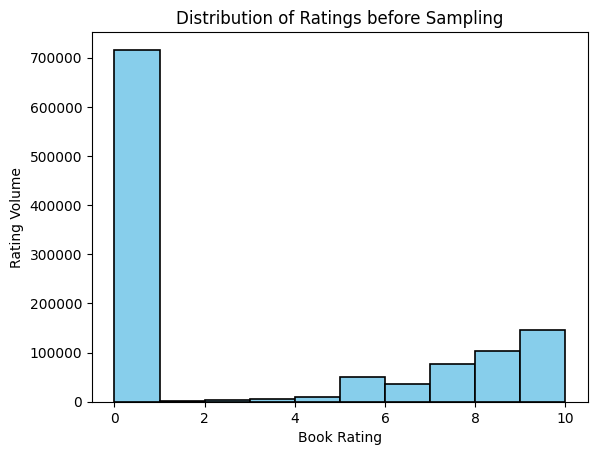

In [3]:
# Plotting the distribution of ratings
import matplotlib.pyplot as plt

# Plotting histogram of ratings
plt.hist(book_ratings_raw_df['Book-Rating'], bins=10, color='skyblue', edgecolor='black', linewidth=1.2)
plt.xlabel('Book Rating')
plt.ylabel('Rating Volume')
plt.title('Distribution of Ratings before Sampling')

---

## Data Loading
#### Sampling the data and storing it in dataframes.

Text(0.5, 1.0, 'Distribution of Ratings after Sampling')

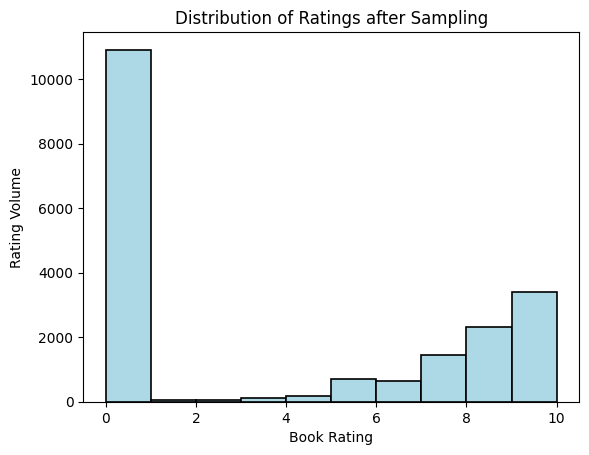

In [4]:
# Size of sampled data
num_books = 100
num_total_ratings = 200

# Data Loading - Getting the top n books based on reviews
top_rated_books = book_ratings_raw_df['ISBN'].value_counts().head(num_books).index
sampled_books_df = books_raw_df[books_raw_df['ISBN'].isin(top_rated_books)]

# Data Loading - Getting ratings of the top n books
book_ISBN = sampled_books_df['ISBN'].unique() # Book ISBNs of the sampled books

full_ratings_df = book_ratings_raw_df[book_ratings_raw_df['ISBN'].isin(book_ISBN)]
sampled_ratings_df = full_ratings_df.groupby('ISBN').head(num_total_ratings)

# Merge ratings with users df to get the age of the user
sampled_ratings_df = pd.merge(sampled_ratings_df, books_users_raw_df, on='User-ID', how='left')

# Plotting the distribution of ratings
import matplotlib.pyplot as plt

# Plotting histogram of ratings
plt.hist(sampled_ratings_df['Book-Rating'], bins=10, color='lightblue', edgecolor='black', linewidth=1.2)
plt.xlabel('Book Rating')
plt.ylabel('Rating Volume')
plt.title('Distribution of Ratings after Sampling')

## Data Cleaning
#### Dropping unnecessary or incomplete features. Checking for missing values in sampled dataset.

In [5]:
# Data cleaning - drop unnecessary columns
sampled_books_df = sampled_books_df.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'])
sampled_ratings_df = sampled_ratings_df.dropna(subset=['Age'])
sampled_ratings_df = sampled_ratings_df.drop(columns=['Location'])

# Print the head row of each dataframe
print(tabulate(sampled_books_df.head(1), headers='keys', tablefmt='psql'))
print(tabulate(sampled_ratings_df.head(1), headers='keys', tablefmt='psql'))

# Check dataframes for n/a, null and missing values
print("Check for missing values in the sampled dataframes")
print(sampled_books_df.isnull().sum())
print(sampled_ratings_df.isnull().sum())

+----+------------+---------------+---------------+-----------------------+-------------+
|    |       ISBN | Book-Title    | Book-Author   |   Year-Of-Publication | Publisher   |
|----+------------+---------------+---------------+-----------------------+-------------|
| 18 | 0440234743 | The Testament | John Grisham  |                  1999 | Dell        |
+----+------------+---------------+---------------+-----------------------+-------------+
+----+-----------+------------+---------------+-------+
|    |   User-ID |       ISBN |   Book-Rating |   Age |
|----+-----------+------------+---------------+-------|
|  1 |    276847 | 0446364193 |             0 |    27 |
+----+-----------+------------+---------------+-------+
Check for missing values in the sampled dataframes
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64
User-ID        0
ISBN           0
Book-Rating    0
Age            0
dtype: int64


### Dataframe Information

In [6]:
# Storing sampled data's book titles, users, and ratings
book_titles = sampled_books_df.set_index('ISBN')['Book-Title'].to_dict()
num_total_books = sampled_books_df['ISBN'].nunique()
num_total_users = sampled_ratings_df['User-ID'].nunique()
num_total_ratings = sampled_ratings_df['Book-Rating'].count()

print(f'Sampled Books dimensions: {sampled_books_df.shape}')
print(f'Sampled Ratings dimensions: {sampled_ratings_df.shape}')

print(f'Total books: {num_total_books}')
print(f'Total ratings: {num_total_ratings}')
print(f'Total users: {num_total_users}')

Sampled Books dimensions: (99, 5)
Sampled Ratings dimensions: (13800, 4)
Total books: 99
Total ratings: 13800
Total users: 5334


---
---

# Creating Matrix Factorization Model

In [7]:
import torch
import torch.nn as nn

class MFModel(nn.Module):
    def __init__(self, number_users, number_objects, n_factors=20, user_feature_dimensions=10):
        super().__init__()
        
        # Create user and item embeddings
        self.user_factors = nn.Embedding(number_users, n_factors)
        self.object_factors = nn.Embedding(number_objects, n_factors)

        # Create user features layer
        self.user_features_linear = nn.Linear(user_feature_dimensions, n_factors)
        
        # Initialize weights
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.object_factors.weight.data.uniform_(0, 0.05)
        self.user_features_linear.weight.data.uniform_(0, 0.05)
    
    def forward(self, data):
        # Extract user and item IDs
        user_IDs = data[:, 1].long()
        objects = data[:, 0].long()          
       
        user_attributes = data[:, 2:]
        
        # Lookup of embeddings
        user_embeddings = self.user_factors(user_IDs)
        item_embeddings = self.object_factors(objects)
        
        # Lookup of user features embeddings
        embeddings_user_features = self.user_features_linear(user_attributes.float()) 
        
        # Combine user embeddings and user features embeddings
        user_features_combined = user_embeddings + embeddings_user_features 

        # Calculate the interaction between the user and the item
        interaction = (user_features_combined * item_embeddings).sum(dim=1)
        
        return interaction


In [8]:
from torch.utils.data.dataloader import Dataset
from torch.utils.data import DataLoader

class PreProcessor(Dataset):
    def __init__(self, books_df, ratings_df):
        # copy ratings dataframe
        self.ratings = ratings_df.copy()

        # getting all user ids and books isbns
        user_ids = ratings_df['User-ID'].unique()
        book_isbns = books_df['ISBN'].unique()

        # creating dictionaries for mappings
        self.user_to_index = {user: idx for idx, user in enumerate(user_ids)}
        self.book_to_index = {game: idx for idx, game in enumerate(book_isbns)}
        self.index_to_user = {idx: user for user, idx in self.user_to_index.items()}
        self.index_to_book = {idx: game for game, idx in self.book_to_index.items()}

        # mapping user ids and book isbns to indexes
        self.ratings['ISBN'] = ratings_df['ISBN'].apply(lambda x: self.book_to_index[x])
        self.ratings['User-ID'] = ratings_df['User-ID'].apply(lambda x: self.user_to_index[x])

        # creating x and y tensors
        self.b = self.ratings[['ISBN','User-ID','Age']].values
        self.r = self.ratings['Book-Rating'].values

        self.b, self.r = torch.tensor(self.b), torch.tensor(self.r)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, index):
        return (self.b[index], self.r[index])

### Matrix Factorization Model Hyperparameters

In [37]:
# Model hyperparameters
epochs = 230
batch_size = 132
n_factors = 3
book_feature_dim = 1

# Checking if system GPU is available for training
cuda_core_is_available = torch.cuda.is_available()

# Creating the model
mf_model = MFModel(num_total_users, num_total_books, n_factors, book_feature_dim)
print(mf_model)

if cuda_core_is_available:
    print("Can utilize GPU for training.")
    torch.cuda.empty_cache()
    mf_model = mf_model.cuda()

# Printing accepted model parameters
for item, parameter in mf_model.named_parameters():
    if parameter.requires_grad:
        print(item, parameter.data)

# Model loss function, optimizer, training data, and initial embeddings
MFmodel_loss = torch.nn.MSELoss()
MFmodel_optimizer = torch.optim.Adam(mf_model.parameters(), lr=1e-3)

training_set = PreProcessor(sampled_books_df, sampled_ratings_df)
print("\nTensor head:",training_set[0])
training_set_loader = DataLoader(training_set, batch_size, shuffle=True)

initial_book_embeddings = mf_model.object_factors.weight.data.cpu().numpy().copy()

MFModel(
  (user_factors): Embedding(5334, 3)
  (object_factors): Embedding(99, 3)
  (user_features_linear): Linear(in_features=1, out_features=3, bias=True)
)
user_factors.weight tensor([[0.0096, 0.0102, 0.0177],
        [0.0428, 0.0108, 0.0407],
        [0.0012, 0.0083, 0.0334],
        ...,
        [0.0252, 0.0405, 0.0147],
        [0.0129, 0.0352, 0.0308],
        [0.0057, 0.0107, 0.0397]])
object_factors.weight tensor([[0.0498, 0.0292, 0.0253],
        [0.0063, 0.0087, 0.0179],
        [0.0029, 0.0200, 0.0283],
        [0.0330, 0.0051, 0.0456],
        [0.0396, 0.0237, 0.0471],
        [0.0483, 0.0004, 0.0470],
        [0.0409, 0.0027, 0.0474],
        [0.0188, 0.0090, 0.0353],
        [0.0230, 0.0025, 0.0096],
        [0.0298, 0.0009, 0.0280],
        [0.0366, 0.0093, 0.0382],
        [0.0189, 0.0357, 0.0385],
        [0.0088, 0.0348, 0.0430],
        [0.0318, 0.0340, 0.0476],
        [0.0414, 0.0291, 0.0097],
        [0.0369, 0.0290, 0.0120],
        [0.0278, 0.0488, 0.0323],
  

## Training the Matrix Factorization Model

### This cell outputs the Epoch number, and loss as the model is trained. As the loss value grows smaller, the accuracy of the model increases.

In [38]:
from tqdm.notebook import tqdm_notebook as tqdm 

print("Model Accuracy")
# matrix factorization training loop
for epoch in tqdm(range(epochs)):
    losses = []
    for b, r in training_set_loader:
        if cuda_core_is_available:
            b, r = b.cuda(), r.cuda()
        
        MFmodel_optimizer.zero_grad()
        y_hat = mf_model(b)
        loss = MFmodel_loss(y_hat.squeeze(), r.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        MFmodel_optimizer.step()
    print(f'Epoch {epoch}, loss: {sum(losses)/len(losses)}')

Model Accuracy


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch 0, loss: 23.954662468319846
Epoch 1, loss: 18.497344362168086
Epoch 2, loss: 17.76364506312779
Epoch 3, loss: 17.6557712100801
Epoch 4, loss: 17.624401083446685
Epoch 5, loss: 17.54645233154297
Epoch 6, loss: 17.49663133167085
Epoch 7, loss: 17.42928972698393
Epoch 8, loss: 17.394744873046875
Epoch 9, loss: 17.304638481140138
Epoch 10, loss: 17.25918473743257
Epoch 11, loss: 17.18630699884324
Epoch 12, loss: 17.100246493021647
Epoch 13, loss: 17.03852858770461
Epoch 14, loss: 16.97363719031924
Epoch 15, loss: 16.884665507362
Epoch 16, loss: 16.80156091962542
Epoch 17, loss: 16.716791552589054
Epoch 18, loss: 16.619019562857492
Epoch 19, loss: 16.539700798761277
Epoch 20, loss: 16.445955839611234
Epoch 21, loss: 16.319263149443128
Epoch 22, loss: 16.231339518229166
Epoch 23, loss: 16.11341004144578
Epoch 24, loss: 15.9967073622204
Epoch 25, loss: 15.886218815758115
Epoch 26, loss: 15.765655145191012
Epoch 27, loss: 15.637581525530134
Epoch 28, loss: 15.494252177647182
Epoch 29, lo

## Retrieving the Final Model Embeddings

In [39]:
# converting factor weights tensor to numpy array
trained_book_embeddings = mf_model.object_factors.weight.data.cpu().numpy()

## Assessing Accuracy of the Matrix Factorization model
#### This is achieved via calculating MSE (mean squared error) between the initial and final embeddings.

In [42]:
from sklearn.metrics import mean_squared_error

# Calculate the MSE
mse = mean_squared_error(initial_book_embeddings, trained_book_embeddings)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.1436063051223755


---

# Visualization 1 - Matrix Factorization Heatmap

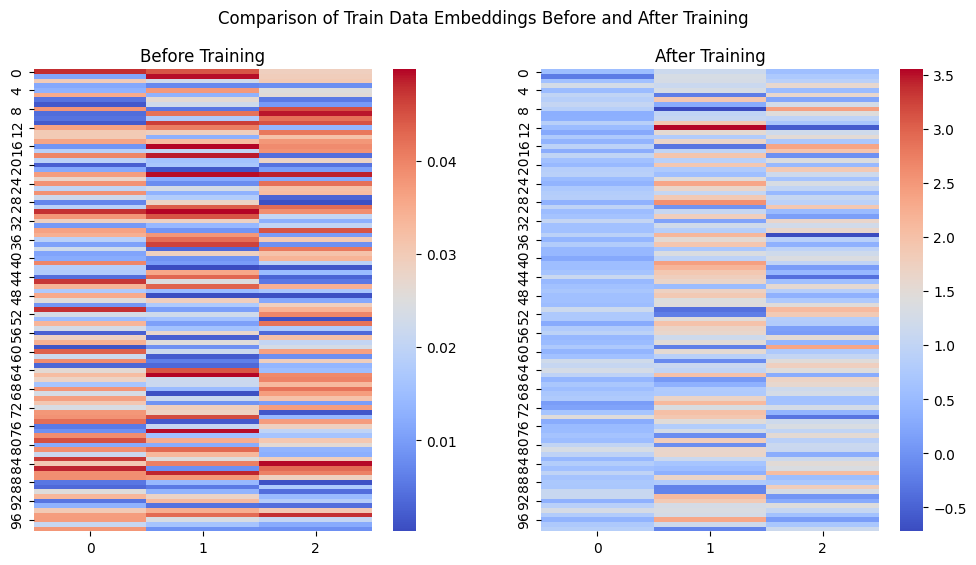

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Creating plots for the embeddings before and after training
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap of data before training
sns.heatmap(initial_book_embeddings, cmap='coolwarm', ax=axs[0])
axs[0].set_title('Before Training')

# Heatmap of the data after training
sns.heatmap(trained_book_embeddings, cmap='coolwarm', ax=axs[1])
axs[1].set_title('After Training')

fig.suptitle('Comparison of Train Data Embeddings Before and After Training')

# Display the plot
plt.show()

---

### K-means Clustering - Elbow Method Visualization
#### - Used to determine the optimal number of clusters to sort books into.

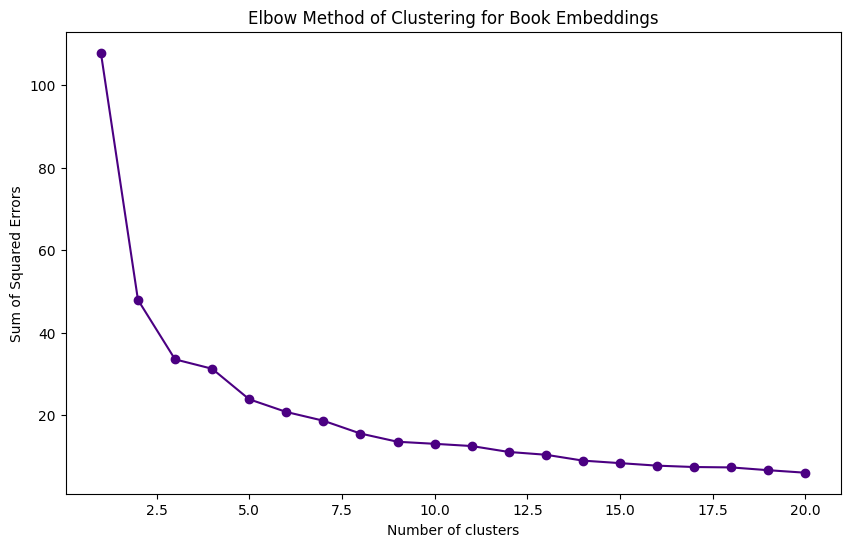

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate the sum of squared errors for different values of k
sum_sqr_errors = []
for k in range(1, 21):
    k_means_model = KMeans(n_clusters=k, random_state=42).fit(trained_book_embeddings)
    sum_sqr_errors.append(k_means_model.inertia_)

# Plot for clusters vs Sum of Squared Errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), sum_sqr_errors, marker='o', color= 'indigo')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method of Clustering for Book Embeddings')

# Display the plot
plt.show()


---

# Visualization #2 - Silhouette Analysis
#### Used to identify the optimal number of clusters for the K-means clustering model. It also examines distribution of items through clusters, and overall accuracy.

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

def plot_silhouette(ax, trained_embeddings, cluster_labels, n_clusters):
    """
    Plot the silhouette scores for the clusters on the given axis.
    
    Parameters:
    - ax: matplotlib axis object to plot on
    - trained_embeddings: numpy array of trained embeddings
    - cluster_labels: array of cluster labels
    - n_clusters: number of clusters
    """
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(trained_embeddings) + (n_clusters + 1) * 10])

    silhouette_scores = silhouette_samples(trained_embeddings, cluster_labels)
    avg_silhouette_score = silhouette_score(trained_embeddings, cluster_labels)
    print(f"{n_clusters} clusters, average silhouette_score is {avg_silhouette_score}.")

    y_lower_bound = 10
    
    for i in range(n_clusters):
        silhouette_values = silhouette_scores[cluster_labels == i]
        silhouette_values.sort()

        size_current_cluster = silhouette_values.shape[0]
        y_upper_bound = y_lower_bound + size_current_cluster

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower_bound, y_upper_bound), 0, silhouette_values, 
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower_bound + 0.5 * size_current_cluster, str(i))
        y_lower_bound = y_upper_bound + 10
    
    ax.set_title("Silhouette plot for the clusters.")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.axvline(x=avg_silhouette_score, color="red", linestyle="--")
    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

def plot_clusters(ax, trained_embeddings, cluster_labels, cluster_centers):
    """
    Plot the clustered data on the given axis.
    
    Parameters:
    - ax: matplotlib axis object to plot on
    - trained_embeddings: numpy array of trained embeddings
    - cluster_labels: array of cluster labels
    - cluster_centers: coordinates of cluster centers
    """
    n_clusters = len(cluster_centers)
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax.scatter(trained_embeddings[:, 0], trained_embeddings[:, 1], 
               marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], 
               marker='o', c="white", alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(cluster_centers):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    ax.set_title("Clustered data visualization.")
    ax.set_xlabel("Feature space 1")
    ax.set_ylabel("Feature space 2")

In [ ]:
from sklearn.cluster import KMeans

def perform_clustering_and_plot(trained_embeddings, k_range):
    """
    Perform clustering and plot silhouette scores and clustered data.
    
    Parameters:
    - trained_embeddings: numpy array of trained embeddings
    - k_range: range of cluster numbers to evaluate
    """
    for k in k_range:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        clustering_model = KMeans(n_clusters=k, random_state=42)
        cluster_labels = clustering_model.fit_predict(trained_embeddings)
        cluster_centers = clustering_model.cluster_centers_

        plot_silhouette(ax1, trained_embeddings, cluster_labels, k)
        plot_clusters(ax2, trained_embeddings, cluster_labels, cluster_centers)

        plt.suptitle(f"Silhouette analysis for n_clusters = {k}", fontsize=14, fontweight='bold')
        plt.show()

2 clusters, average silhouette_score is 0.45685380697250366.


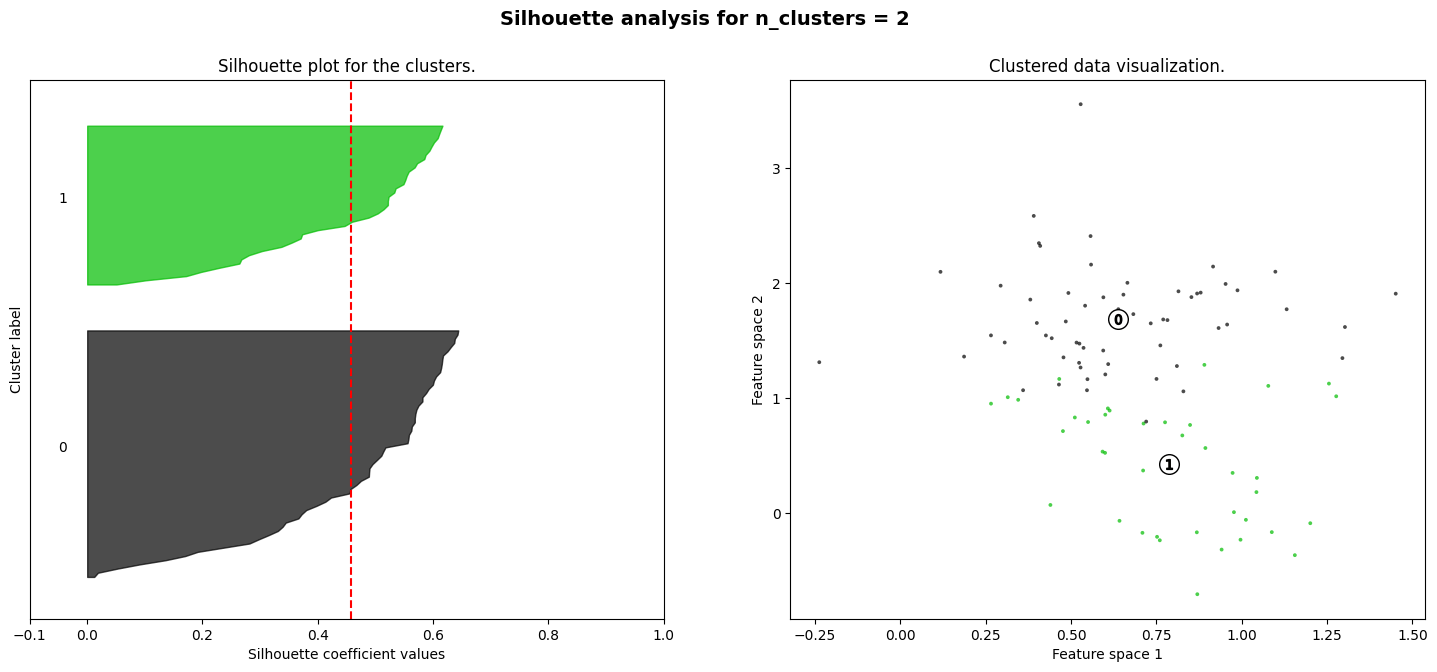

3 clusters, average silhouette_score is 0.3745094835758209.


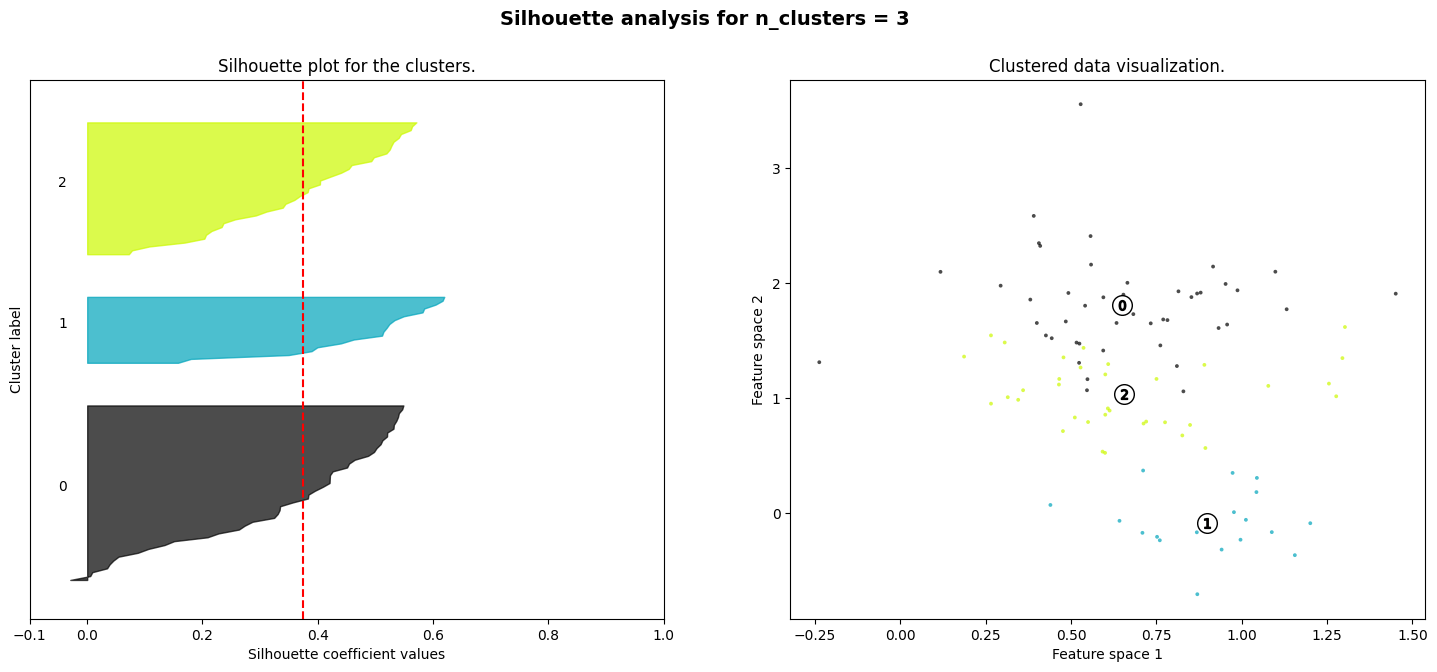

4 clusters, average silhouette_score is 0.31257936358451843.


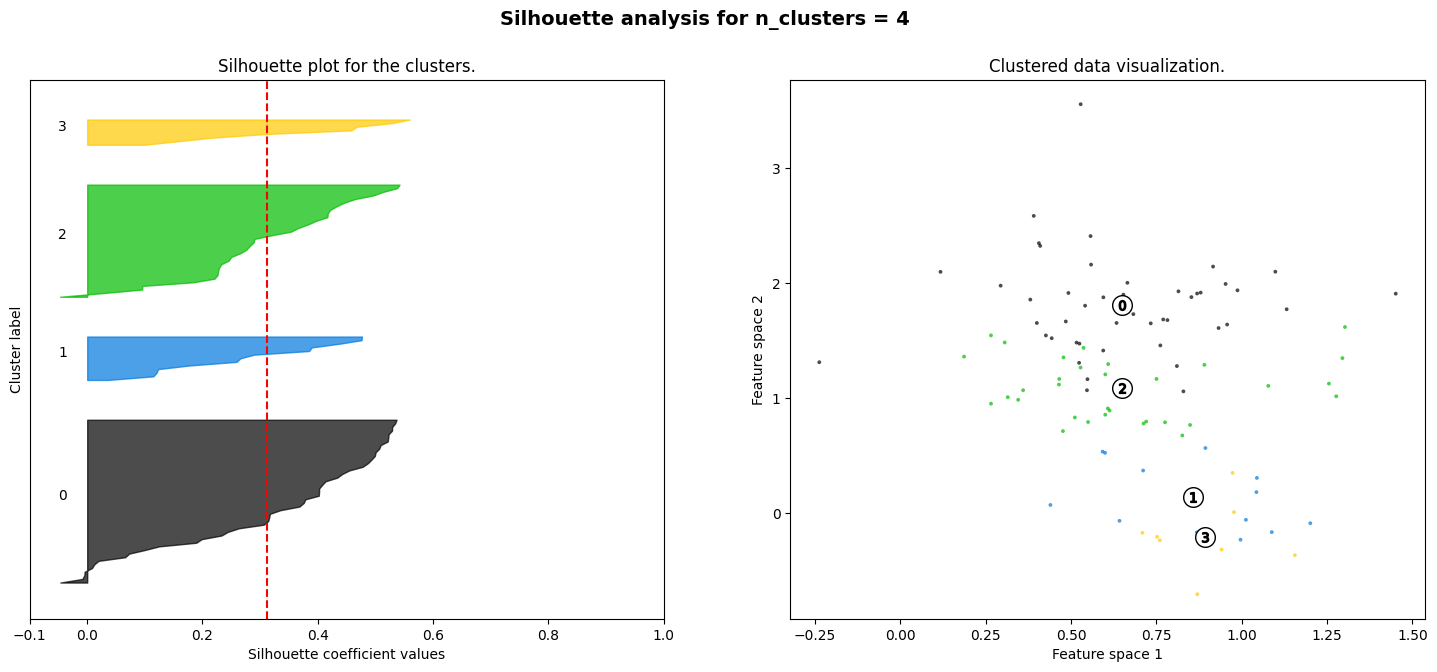

5 clusters, average silhouette_score is 0.293292373418808.


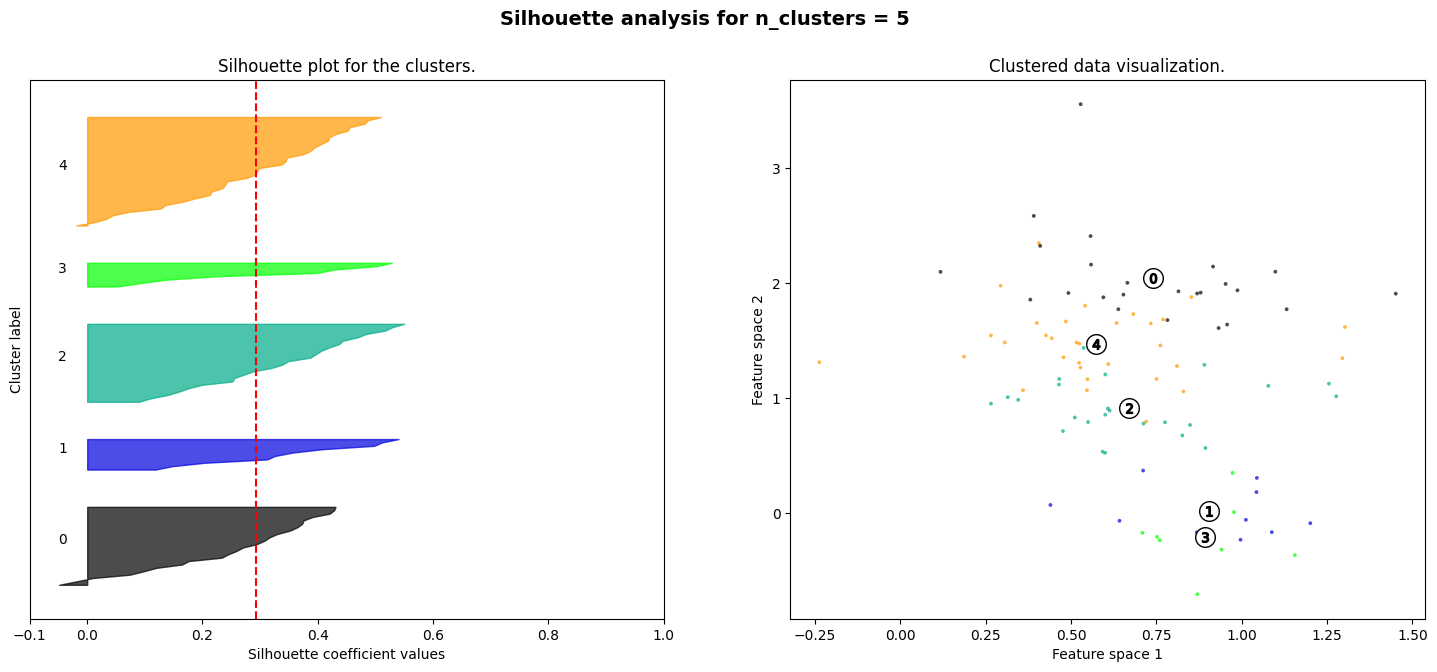

6 clusters, average silhouette_score is 0.29507753252983093.


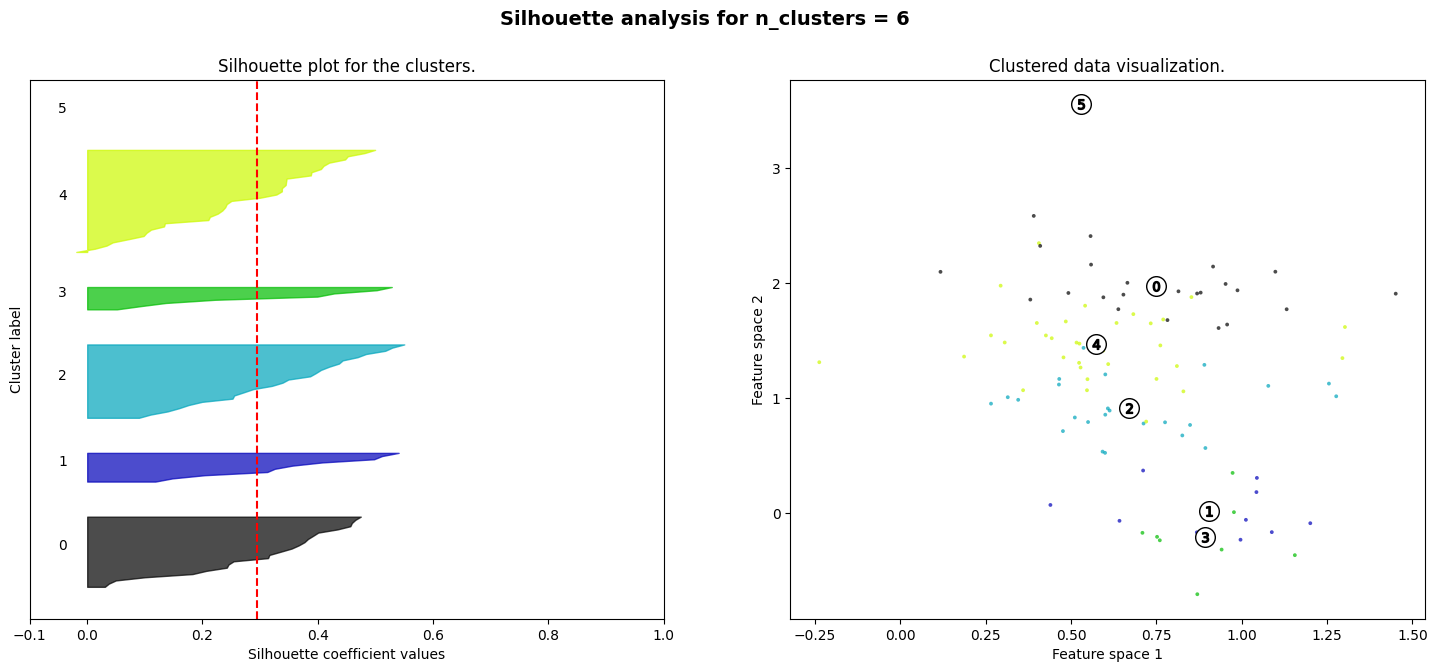

7 clusters, average silhouette_score is 0.29890477657318115.


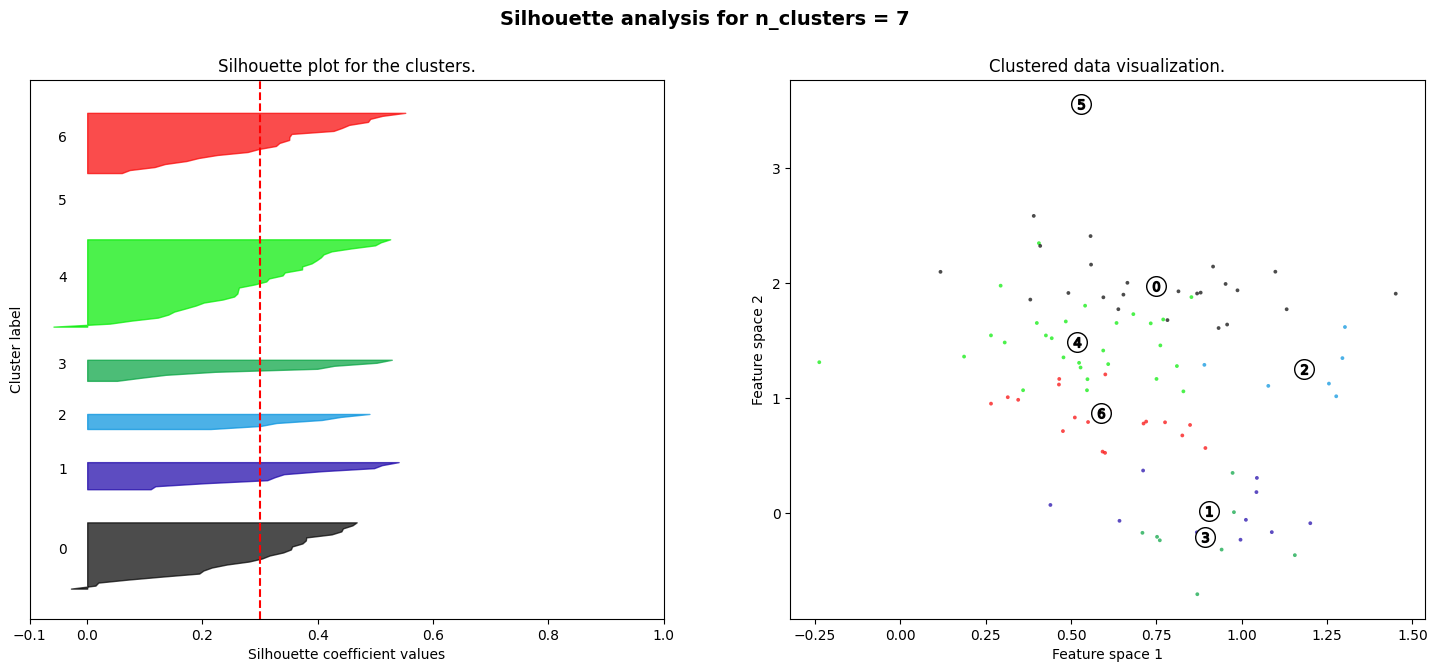

8 clusters, average silhouette_score is 0.28246036171913147.


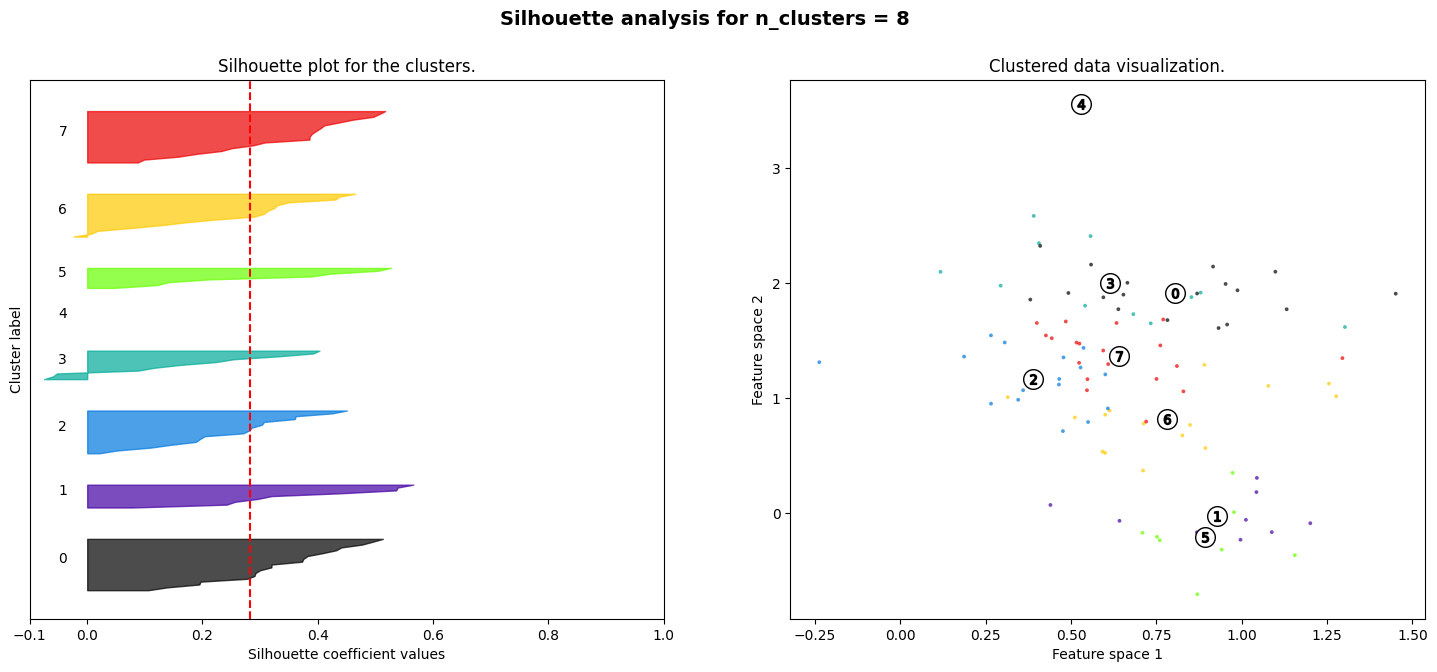

9 clusters, average silhouette_score is 0.2961834967136383.


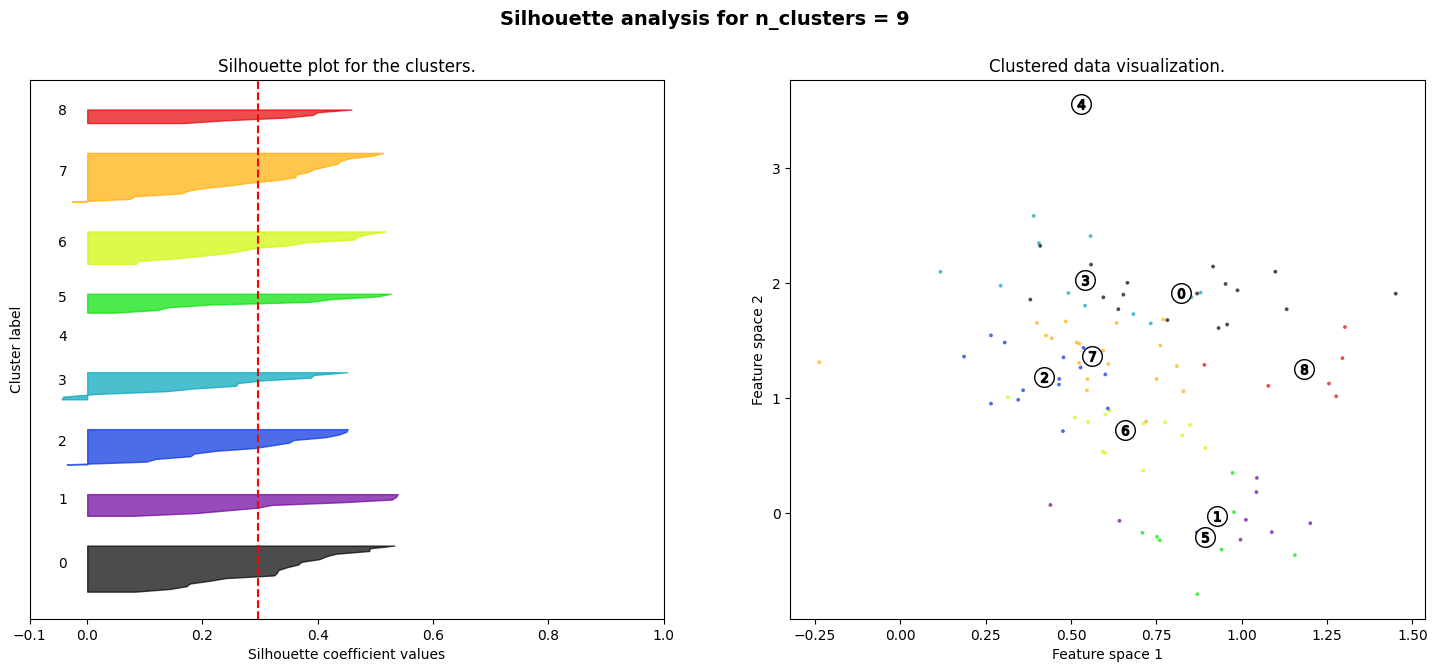

In [ ]:
# plotting the silhouette scores and clustered data
perform_clustering_and_plot(trained_book_embeddings, range(2, 10))

## Fitting K-mean Clustering Model and training with Optimal K Value

In [ ]:
from sklearn.cluster import KMeans
optimal_k = 4

# fitting K-means model to trained book embeddings
k_means_model = KMeans(n_clusters=optimal_k, random_state=42).fit(trained_book_embeddings)

In [ ]:
# Placeholder for cluster information
all_clustered_books = []

# Enumerate through the clusters and get the books in each cluster
for i in range(optimal_k):
    individual_cluster_books = []

    for book_index in np.where(k_means_model.labels_ == i)[0]:
        book_ISBN = training_set.index_to_book[book_index]
        individual_cluster_books.append(book_titles[book_ISBN])

    all_clustered_books.append({'Cluster': f'Cluster {i}', 'Books': '\n'.join(sorted(individual_cluster_books))})

# Print cluster information
print(tabulate(all_clustered_books, headers='keys', tablefmt='psql'))

+-----------+---------------------------------------------------------------------------+
| Cluster   | Books                                                                     |
|-----------+---------------------------------------------------------------------------|
| Cluster 0 | A Heartbreaking Work of Staggering Genius                                 |
|           | A Prayer for Owen Meany                                                   |
|           | A Walk to Remember                                                        |
|           | Along Came a Spider (Alex Cross Novels)                                   |
|           | American Gods                                                             |
|           | Bridget Jones's Diary                                                     |
|           | Confessions of a Shopaholic (Summer Display Opportunity)                  |
|           | Fall On Your Knees (Oprah #45)                                            |
|         

## Assessing Accuracy of the K-means Clustering Model
#### Computes the average silhouette score of the model. The smaller this value is, the more accurate the model is.

In [43]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(trained_book_embeddings, k_means_model.labels_)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: -0.007502773776650429


---

### Pie Chart for Cluster Density
#### Shows the distribution of books through all of the clusters.

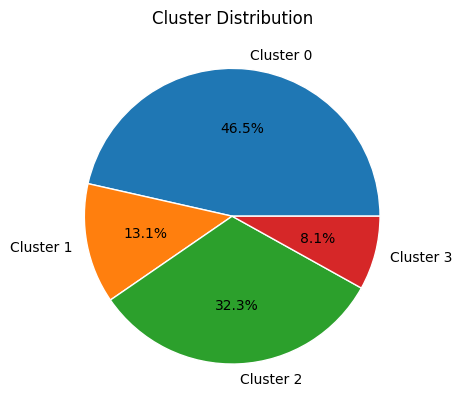

In [ ]:
import matplotlib.pyplot as plt

def create_cluster_pie_chart(cluster_labels, cluster_info):
    """
    Creates a pie chart to visualize the distribution of data points in each cluster.

    Parameters:
    - cluster_labels (numpy.ndarray): Array of cluster labels for each data point.
    - cluster_info (list): List of dictionaries containing information about each cluster.

    Returns:
    None
    """

    # Count the number of data points in each cluster
    cluster_counts = [len(cluster_labels[cluster_labels == i]) for i in range(len(cluster_info))]

    # Create a pie chart
    plt.pie(cluster_counts, labels=[cluster['Cluster'] for cluster in cluster_info], autopct='%1.1f%%', wedgeprops=dict(edgecolor='white'))
    plt.title('Cluster Distribution')

    # Display the chart
    plt.show()

# Create a pie chart to visualize the distribution of data points in each cluster
create_cluster_pie_chart(k_means_model.labels_, all_clustered_books)


# Visualization #3 - K-means Clustering Groups Scatter Plot

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_clusters(trained_book_embeddings, kmeans):
    """
    Visualizes the clusters generated by K-means algorithm using PCA for dimensionality reduction.

    Parameters:
    trained_book_embeddings (array-like): The trained book embeddings.
    kmeans (KMeans): The trained K-means model.

    Returns:
    None
    """

    # Get the labels assigned by K-means
    y_cluster_labels = kmeans.labels_

    # Reduce dimensions with PCA for visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(trained_book_embeddings)

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=y_cluster_labels, s=50, cmap='viridis')

    # Plot the centroids
    centers_2d = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='magenta', s=200, alpha=0.75, marker='x')

    plt.title('K-means Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

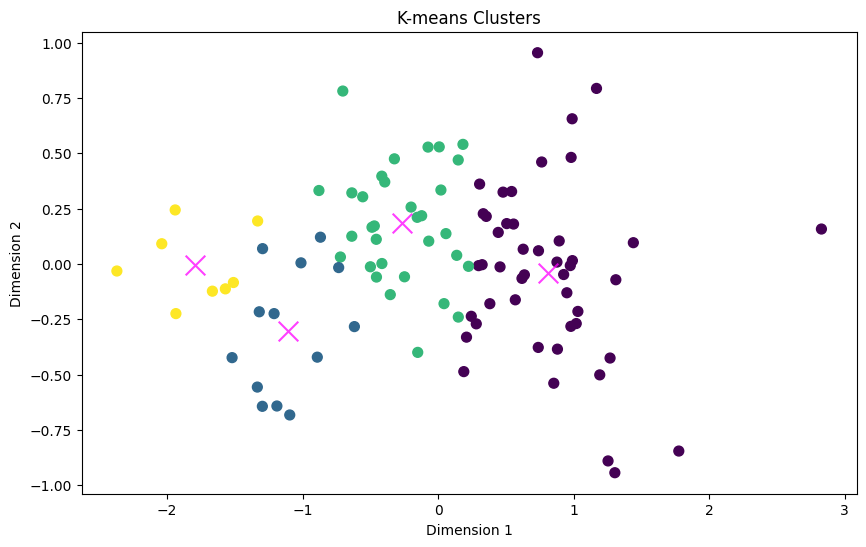

In [ ]:
# Creating scatter plot of the clusters
visualize_clusters(trained_book_embeddings, k_means_model)

---
---
# Interactive User Interface

In [ ]:
import numpy as np
from ipywidgets import widgets
from IPython.display import display, clear_output

class BookClusterWidget:
    """
    A widget for displaying and interacting with book clusters.

    Attributes:
    - book_titles (dict): A dictionary mapping book titles to their corresponding indices.
    - sampled_books_df (pandas.DataFrame): A DataFrame containing information about sampled books.
    - training_set (TrainingSet): An object representing the training set of books.
    - trained_book_embeddings (numpy.ndarray): An array of trained book embeddings.
    - k_means_model (KMeans): A trained K-means clustering model.

    Methods:
    - get_book_cluster(book_title): Returns the cluster index of a given book title.
    - get_cluster_books(cluster): Returns a list of books in the same cluster as the given cluster index.
    - on_book_selected(change): Event handler for when a book is selected from the dropdown widget.
    - display_cluster_books(book_title): Displays the books from the same cluster as the selected book.
    """

    def __init__(self, book_titles, sampled_books_df, training_set, trained_book_embeddings, k_means_model):
        self.book_titles = book_titles
        self.sampled_books_df = sampled_books_df
        self.training_set = training_set
        self.trained_book_embeddings = trained_book_embeddings
        self.k_means_model = k_means_model

        # Create a dropdown widget for selecting a book
        self.book_dropdown = widgets.Dropdown(
            options=book_titles.values(),
            description='eBook:',
            disabled=False,
        )
        
        # Link the dropdown widget to the display function
        self.book_dropdown.observe(self.on_book_selected, names='value')
        display(self.book_dropdown)

    def get_book_cluster(self, book_title):
        """
        Returns the cluster index of a given book title.

        Parameters:
        - book_title (str): The title of the book.

        Returns:
        - cluster (int): The cluster index of the book.
        """
        book_ISBN = self.sampled_books_df[self.sampled_books_df['Book-Title'] == book_title].iloc[0]['ISBN']
        book_index = self.training_set.book_to_index[book_ISBN]
        book_embedding = self.trained_book_embeddings[book_index].reshape(1, -1)
        
        cluster = self.k_means_model.predict(book_embedding)[0]
        return cluster

    def get_cluster_books(self, cluster):
        """
        Returns a list of books in the same cluster as the given cluster index.

        Parameters:
        - cluster (int): The cluster index.

        Returns:
        - cluster_books (list): A list of books in the same cluster.
        """
        cluster_books = [
            self.book_titles[self.training_set.index_to_book[book_idx]]
            for book_idx in np.where(self.k_means_model.labels_ == cluster)[0]
        ]
        return cluster_books

    def on_book_selected(self, change):
        """
        Event handler for when a book is selected from the dropdown widget.

        Parameters:
        - change (dict): The change event object.
        """
        book_title = change['new']
        self.display_cluster_books(book_title)

    def display_cluster_books(self, book_title):
        """
        Displays the books from the same cluster as the selected book.

        Parameters:
        - book_title (str): The title of the selected book.
        """
        clear_output(wait=True)
        display(self.book_dropdown)
        cluster = self.get_book_cluster(book_title)
        cluster_books = self.get_cluster_books(cluster)
        print(f'Books similar to "{book_title}":')
        for book in cluster_books:
            print(book)

In [ ]:
# Create the book cluster widget
book_cluster_widget = BookClusterWidget(book_titles, sampled_books_df, training_set, trained_book_embeddings, k_means_model)

Dropdown(description='eBook:', options=('The Testament', 'Wild Animus', 'Timeline', 'To Kill a Mockingbird', '…